In [154]:
import time

from checkers import *
from heuristic import *

# from minimax_alphabeta import *
from minimax_alphabeta import AI
from util.helpers import *

In [155]:
def generate_samples(N, depth=10):
    samples = []
    for i in range(N):
        WP, BP, K = get_fresh_board()
        player = random.choice([PlayerTurn.WHITE, PlayerTurn.BLACK])
        for move in range(0, random.randint(1, depth)):
            lm = generate_legal_moves(WP, BP, K, player)
            if not lm:
                player = switch_player(player)  # Switch to the player who couldn't move
                break  # Current player loses or draws
            WP, BP, K = do_move(WP, BP, K, random.choice(lm), player=player)
            player = switch_player(player)

        num_legal_moves = len(lm) if lm else 0
        samples.append(
            (
                WP,
                BP,
                K,
                0 if player == PlayerTurn.WHITE else 1,  # 0 for white, 1 for black
                num_legal_moves,
            )
        )
    return samples

In [156]:
N = 1000
samples_to_100 = generate_samples(N, depth=200)

In [157]:
X = (
    # samples_to_2
    # + samples_to_5
    # samples_to_10
    # + samples_to_20
    # samples_to_40
    # + samples_to_60
    # + samples_to_80
    samples_to_100
)
Y = [
    smart(*tup, 0, (tup[0], tup[1], tup[2])) for tup in X
]  # depth 0 and global board state matches current board state


print(X)
print(Y)

[(3760455968, 0, 256, 0, 0), (0, 2282783760, 2281701376, 1, 0), (2098305, 0, 2097281, 0, 0), (0, 603980032, 603980032, 1, 0), (3129999360, 33688, 0, 0, 7), (77795584, 2147533347, 2147483648, 0, 7), (4, 1074790401, 1073741828, 0, 1), (4283957248, 361727, 0, 0, 2), (0, 8454144, 8388608, 1, 0), (4102, 538968065, 538968070, 0, 2), (0, 8389419, 8388864, 1, 0), (51905536, 0, 1024, 0, 0), (0, 813728078, 813694976, 1, 0), (1197096, 134217728, 134217768, 1, 10), (4128243712, 8470653, 0, 0, 2), (0, 671162369, 536879104, 1, 0), (262192, 0, 262160, 0, 0), (88086658, 0, 130, 0, 0), (1234174096, 0, 16, 0, 0), (8384, 18878720, 2097280, 1, 6), (866254848, 16512, 131072, 1, 10), (404226688, 0, 128, 0, 0), (3, 2214592512, 2214592515, 1, 4), (50331968, 0, 33554432, 0, 0), (16, 876675072, 809566224, 1, 2), (3227516948, 67109120, 67108868, 0, 3), (4096, 0, 4096, 0, 0), (1090879488, 0, 65536, 0, 0), (2147483648, 1107427328, 1073741824, 0, 1), (268648457, 16777216, 9, 0, 0), (16576, 0, 16448, 0, 0), (1049728

In [158]:
def int_to_binary_array(num):
    return [int(digit) for digit in f"{num:032b}"]


def prepare_sample(sample):
    WP, BP, K, player_turn, num_legal_moves = sample
    WP_binary = int_to_binary_array(WP)
    BP_binary = int_to_binary_array(BP)
    K_binary = int_to_binary_array(K)
    # return WP_binary + BP_binary + K_binary + [player_turn, num_legal_moves] + [count_bits(WP)] + [count_bits(BP)] + [count_bits(WP & K)] + [count_bits(BP & K)]
    return (
        [player_turn, num_legal_moves]
        + [count_bits(WP)]
        + [count_bits(BP)]
        + [count_bits(WP & K)]
        + [count_bits(BP & K)]
    )


# Prepare all samples
X_processed = [prepare_sample(sample) for sample in X]

In [159]:
print(X_processed[0])
X = X_processed

[0, 0, 7, 0, 1, 0]


Length of X: 1000
Length of Y: 1000
Number of features in each sample of X: 6
Average value of Y: 58.77
Maximum value in Y: 1259
Minimum value in Y: -1243


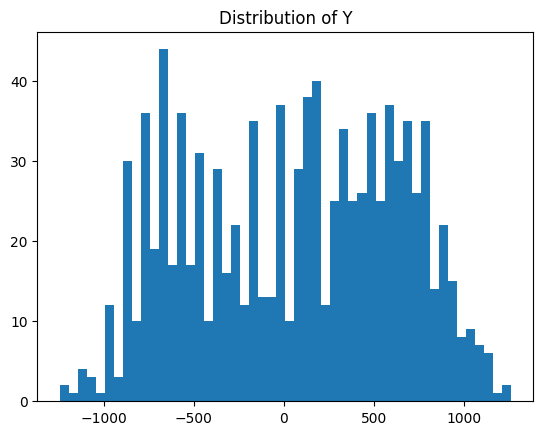

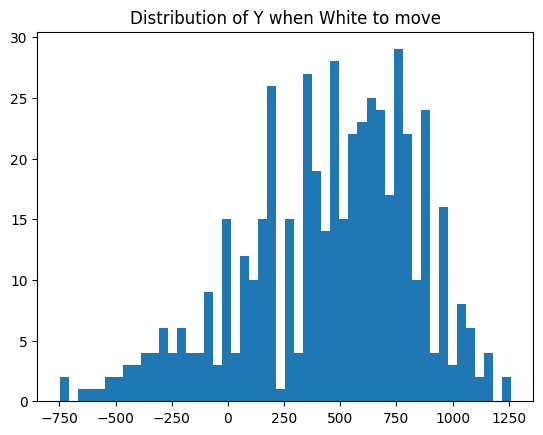

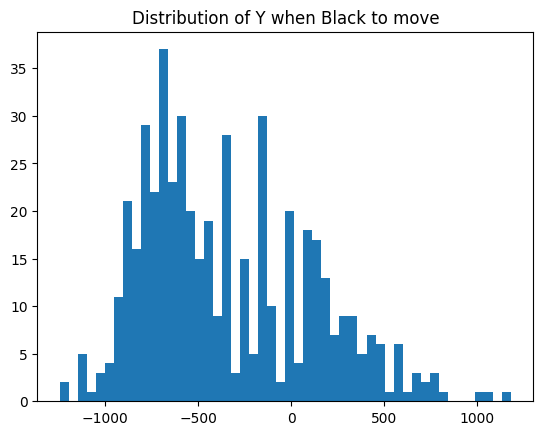

In [179]:
print(f"Length of X: {len(X)}")
print(f"Length of Y: {len(Y)}")
print(f"Number of features in each sample of X: {len(X[0])}")
print(f"Average value of Y: {sum(Y) / len(Y):.2f}")
print(f"Maximum value in Y: {max(Y)}")
print(f"Minimum value in Y: {min(Y)}")

import matplotlib.pyplot as plt

plt.title("Distribution of Y")
plt.hist(Y, bins=50)
plt.show()

# make two seperate of histograms for Y grouped by player turn
plt.title("Distribution of Y when White to move")
plt.hist([y for i, y in enumerate(Y) if X[i][0] == 0], bins=50)
plt.show()

plt.title("Distribution of Y when Black to move")
plt.hist([y for i, y in enumerate(Y) if X[i][0] == 1], bins=50)
plt.show()

In [161]:
import torch
import torch.nn as nn
import torch.optim as optim

In [168]:
class CheckersNN(nn.Module):
    def __init__(self):
        super(CheckersNN, self).__init__()
        self.fc1 = nn.Linear(6, 64)  # Adjust 'in_features' based on your input size
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Linear activation for the output layer
        return x

In [169]:
X_tensor = torch.FloatTensor(X)  # Assuming X is already in a suitable numeric format
Y_tensor = torch.FloatTensor(Y)

In [170]:
model = CheckersNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(), lr=0.01, betas=(0.999, 0.999)
)  # Learning rate can be adjusted

In [171]:
def train_model(model, criterion, optimizer, X, Y, epochs=100, print_every=10):
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

            # Print model predictions and true evaluations for a subset of data
            with torch.no_grad():
                sample_indices = torch.randint(
                    0, X.size(0), (5,)
                )  # Select 5 random samples
                for i in sample_indices:
                    prediction = model(X[i]).item()
                    true_value = Y[i].item()
                    print(
                        f"Sample {i}: Prediction = {prediction}, True Value = {true_value}"
                    )

In [172]:
train_model(model, criterion, optimizer, X_tensor, Y_tensor, epochs=1000, print_every=10)


/usr/local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/1000], Loss: 334313.8125
Sample 802: Prediction = 7.32710599899292, True Value = -874.0
Sample 183: Prediction = 11.022770881652832, True Value = 185.0
Sample 270: Prediction = 2.3730459213256836, True Value = -167.0
Sample 65: Prediction = 7.446550369262695, True Value = 933.0
Sample 934: Prediction = 10.131563186645508, True Value = -593.0
Epoch [20/1000], Loss: 332531.6875
Sample 39: Prediction = 33.633487701416016, True Value = 881.0
Sample 988: Prediction = 13.926151275634766, True Value = 302.0
Sample 452: Prediction = 51.48454666137695, True Value = -20.0
Sample 836: Prediction = 38.960487365722656, True Value = -941.0
Sample 50: Prediction = 35.67865753173828, True Value = -792.0
Epoch [30/1000], Loss: 333093.8125
Sample 966: Prediction = 57.856689453125, True Value = 782.0
Sample 780: Prediction = 38.587860107421875, True Value = 482.0
Sample 888: Prediction = 145.12388610839844, True Value = -44.0
Sample 118: Prediction = 91.09620666503906, True Value = 6.0
Sample 4

In [ ]:
torch.save(model.state_dict(), 'NN/checkers_nn.pth')